In [149]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from models.HEGNN import HEGNN  
import rdkit.Chem.rdMolTransforms as rdMolTransforms 

#If using earlier than python3.9 version
from typing import Tuple, List


In [150]:
# Load the data
train_df = pd.read_excel('Training_data_cleaned.xlsx')
val_df = pd.read_excel('Validation_data_cleaned.xlsx')
test_df = pd.read_excel('Test_data_cleaned.xlsx')

# While testing, only use the first 500 samples
# train_df = train_df.iloc[:500]
# val_df = val_df.iloc[:500]
# test_df = test_df.iloc[:500]


In [151]:
def balance_datasets(dataframe: pd.DataFrame) -> pd.DataFrame:

    """
    This filters the dataset to have a X:1 ratio of 0 value mols to 1 value mols
    Args:
        dataframe (pd.DataFrame): the dataset dataframe
    Return:
        pd.DataFrame: the filtered dataframe
    
    """
    function_one_df = dataframe[dataframe['Function'] == 1]
    function_zero_df = dataframe[dataframe['Function'] == 0]

    num_function_one = function_one_df.shape[0]

    # Calculate the number of rows to take from 'Function' == 0 (X:1 ratio)
    num_function_zero = min(3 * num_function_one, function_zero_df.shape[0]) #2* 

    balanced_function_zero_df = function_zero_df.sample(n=num_function_zero, random_state=42)
    balanced_train_df = pd.concat([function_one_df, balanced_function_zero_df])

    return balanced_train_df

In [152]:
train_df = balance_datasets(train_df)
val_df = balance_datasets(val_df)
test_df = balance_datasets(test_df)

In [153]:
torch.manual_seed(42)
np.random.seed(42)

In [154]:
from tqdm import tqdm
class MoleculeDataset(Dataset):
    """
    Custom Dataset for molecule data.

    Args:
        dataframe (pd.DataFrame): DataFrame containing molecule data.
    """
    def __init__(self, dataframe: pd.DataFrame):
        self.data_list = []
        #self.smiles = None
        for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
            smiles = row['Main_Component']
            label = row['Function']
            try:
                mol = Chem.MolFromSmiles(smiles)
            except:
                mol = None
                print(f'Failed to process SMILES: {smiles}')
            if mol is None:
                continue
            data = mol_to_graph_data(mol, smiles)
            if data is None:
                print("Data was None")
                continue
            data.y = torch.tensor([label], dtype=torch.float)
            self.data_list.append(data)

    def __len__(self) -> int:
        return len(self.data_list)

    def __getitem__(self, idx: int):
        return self.data_list[idx]

def atom_features(atom):
    """
    Returns a list of atom features.

    Args:
        atom (Chem.Atom): RDKit atom object.

    Returns:
        List[float]: List of features.
    """
    features = []
    features.append(atom.GetAtomicNum())
    features.append(atom.GetDegree())
    features.append(atom.GetFormalCharge())
    features.append(atom.GetNumRadicalElectrons())
    features.append(int(atom.GetHybridization()))
    features.append(int(atom.GetIsAromatic()))
    features.append(atom.IsInRing())
    features.append(int(atom.GetIsAromatic()))
    features.append(atom.GetMass())
    return features


# Function to convert bond types to numeric values 
 def bond_type_to_numeric(bond_type): 
     bond_mapping = {'SINGLE': 0, 'DOUBLE': 1, 'TRIPLE': 2, 'AROMATIC': 3} 
     return bond_mapping.get(bond_type, -1) 


# Function to calculate bond angles 
 def calc_bond_angle(mol, atom1_idx, atom2_idx): 
     neighbors1 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom1_idx).GetNeighbors() if nbr.GetIdx() != atom2_idx] 
     neighbors2 = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(atom2_idx).GetNeighbors() if nbr.GetIdx() != atom1_idx] 
     if neighbors1 and neighbors2: 
         return rdMolTransforms.GetAngleDeg(mol.GetConformer(), neighbors1[0], atom1_idx, atom2_idx)
     return None 


# Function to check if a bond is rotatable 
 def is_rotatable_bond(bond): 
     if bond.GetBondType() != Chem.rdchem.BondType.SINGLE:
         return False 
     return (not bond.GetBeginAtom().IsInRing() and bond.GetBeginAtom().GetDegree() > 1 and 
             not bond.GetEndAtom().IsInRing() and bond.GetEndAtom().GetDegree() > 1)


# Conformer generation with fallback 
 def generate_conformer(mol, max_attempts=1000): 
     params = AllChem.ETKDG()
     params.maxAttempts = max_attempts
     try: 
         success = AllChem.EmbedMolecule(mol, params)
         if success == -1: 
             return None  # Failed to generate conformer 
         try: 
             AllChem.UFFOptimizeMolecule(mol) 
         except ValueError: 
             if not AllChem.MMFFOptimizeMolecule(mol): 
                 return None 
     except Exception as e: 
         print(f'Conformer generation error: {e}') 
         return None 
     return mol 


def mol_to_graph_data(mol: Chem.Mol, smiles_name) -> Data:
    """
    Converts an RDKit Mol object to a PyTorch Geometric Data object.

    Args:
        mol (Chem.Mol): RDKit molecule object.

    Returns:
        data (Data): PyTorch Geometric Data object.
    """
    # Add hydrogens and generate 3D coordinates
    mol = Chem.AddHs(mol)
    success = AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    if success != 0:
        return None  # Failed to generate conformer
    AllChem.UFFOptimizeMolecule(mol)

    # Nodes
    num_atoms = mol.GetNumAtoms()
    node_feats = []
    node_positions = []
    for atom in mol.GetAtoms():
        node_feats.append(atom_features(atom))
        pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        node_positions.append([pos.x, pos.y, pos.z])

    node_feats = torch.tensor(node_feats, dtype=torch.float)
    node_positions = torch.tensor(node_positions, dtype=torch.float)

    # Edges
    edge_index = []
    edge_attrs = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])  # Undirected
        bond_type = bond.GetBondTypeAsDouble()
        edge_attrs.extend([[bond_type], [bond_type]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attrs = torch.tensor(edge_attrs, dtype=torch.float)

    # Node velocities as small random values
    node_velocities = torch.randn_like(node_positions) * 0.01

    data = Data(
        x=node_feats,
        pos=node_positions,
        vel=node_velocities,
        edge_index=edge_index,
        edge_attr=edge_attrs,
        smiles = smiles_name
    )

    return data


In [155]:
# Create datasets
train_dataset = MoleculeDataset(train_df)
val_dataset = MoleculeDataset(val_df)
test_dataset = MoleculeDataset(test_df)

# Create DataLoaders
batch_size = 32
print(f"Number of training samples: {len(train_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Number of validation samples: {len(val_dataset)}")
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print(f"Number of test samples: {len(test_dataset)}")
test_loader = DataLoader(test_dataset, batch_size=batch_size)


  3%|▎         | 29/832 [00:03<01:32,  8.67it/s]

Data was None


 22%|██▏       | 185/832 [00:17<00:52, 12.33it/s]

Data was None


 25%|██▌       | 211/832 [00:20<00:49, 12.60it/s][12:44:53] UFFTYPER: Unrecognized charge state for atom: 3
[12:44:53] UFFTYPER: Unrecognized charge state for atom: 3
 29%|██▉       | 243/832 [00:22<01:00,  9.73it/s][12:44:55] UFFTYPER: Unrecognized atom type: Ni6+2 (1)
[12:44:55] UFFTYPER: Unrecognized atom type: Ni6+2 (1)
 52%|█████▏    | 431/832 [00:39<00:42,  9.36it/s][12:45:12] UFFTYPER: Unrecognized atom type: Au6+3 (7)
[12:45:12] UFFTYPER: Unrecognized atom type: Au6+3 (7)
 56%|█████▋    | 469/832 [00:40<00:18, 19.81it/s]

Data was None


 65%|██████▍   | 539/832 [00:43<00:16, 17.35it/s][12:45:16] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[12:45:16] UFFTYPER: Warning: hybridization set to SP3 for atom 1
 90%|█████████ | 750/832 [00:54<00:04, 17.19it/s]

Data was None


 23%|██▎       | 41/180 [00:10<01:59,  1.16it/s]

Data was None


 25%|██▌       | 45/180 [00:11<00:57,  2.33it/s][12:45:44] UFFTYPER: Unrecognized atom type: Au6+3 (6)
[12:45:44] UFFTYPER: Unrecognized atom type: Au6+3 (6)
  8%|▊         | 15/180 [00:01<00:15, 10.99it/s][12:45:51] UFFTYPER: Warning: hybridization set to SP3 for atom 20
[12:45:51] UFFTYPER: Warning: hybridization set to SP3 for atom 20
 39%|███▉      | 71/180 [00:07<00:26,  4.15it/s][12:45:57] UFFTYPER: Unrecognized charge state for atom: 14
[12:45:57] UFFTYPER: Unrecognized charge state for atom: 14
 43%|████▎     | 77/180 [00:08<00:25,  4.09it/s]

Data was None


100%|██████████| 180/180 [00:15<00:00, 11.58it/s]

Number of training samples: 828
Number of validation samples: 179
Number of test samples: 179


In [156]:
# Initialize the HEGNN model and classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model parameters
num_layers = 3
mol = Chem.MolFromSmiles('CCO')
node_input_dim = len(atom_features(mol.GetAtomWithIdx(0)))
edge_attr_dim = 1   # Bond type
hidden_dim = 64
max_ell = 2  # Example value

# Initialize the HEGNN
heg_nn = HEGNN(
    num_layer=num_layers,
    node_input_dim=node_input_dim,
    edge_attr_dim=edge_attr_dim,
    hidden_dim=hidden_dim,
    max_ell=max_ell,
    activation=nn.SiLU(),
    device=device
).to(device)

class HEGNNClassifier(nn.Module):
    """
    Model that combines HEGNN and a linear classifier.

    Args:
        heg_nn (HEGNN): The HEGNN model.
        hidden_dim (int): Dimension of the HEGNN output.
    """
    def __init__(self, heg_nn: HEGNN, hidden_dim: int):
        super(HEGNNClassifier, self).__init__()
        self.heg_nn = heg_nn
        self.classifier = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        node_feat = data.x
        node_pos = data.pos
        node_vel = data.vel
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        node_embeddings = self.heg_nn(node_feat, node_pos, node_vel, edge_index, edge_attr)
        graph_embeddings = global_mean_pool(node_embeddings, batch)
        out = self.classifier(graph_embeddings)
        return out, graph_embeddings

# Initialize the classifier model
model = HEGNNClassifier(heg_nn, hidden_dim).to(device)


In [157]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [158]:
def train(model: nn.Module, loader: DataLoader) -> float:
    """
    Training loop for one epoch.

    Args:
        model (nn.Module): The model to train.
        loader (DataLoader): DataLoader for training data.

    Returns:
        float: Average loss over the epoch.
    """
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, _ = model(data)
        label = data.y.view(-1, 1)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)


In [159]:
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Evaluation loop.

    Args:
        model (nn.Module): The model to evaluate.
        loader (DataLoader): DataLoader for validation or test data.

    Returns:
        Tuple[float, np.ndarray, np.ndarray]: Average loss, predictions, and labels.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, _ = model(data)
            label = data.y.view(-1, 1)
            loss = criterion(out, label)
            total_loss += loss.item() * data.num_graphs
            preds = torch.sigmoid(out).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


In [160]:
def get_accuracy(predictions: np.ndarray, labels: np.ndarray) -> float:
    """
    Converts sigmoid prediction to binary values and computes accuracy

    Args: 
        predictions (np.ndarray): Sigmoid prediction values
        labels (np.ndarray): True binary labels

    Returns:
        float: The accuracy score
    """

    binary_preds = []
    for prediction in predictions:
        if prediction >= .5:
            binary_preds.append(1)
        else:
            binary_preds.append(0)
    binary_preds = np.array(binary_preds)
    accuracy = accuracy_score(binary_preds, labels)

    return accuracy

In [161]:
# Training loop execution
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader)
    val_loss, val_preds, val_labels = evaluate(model, val_loader)

    val_accuracy = get_accuracy(val_preds, val_labels)
    
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1, Train Loss: 0.6640, Validation Loss: 0.6321, Validation Accuracy: 0.7542
Epoch 2, Train Loss: 0.6111, Validation Loss: 0.5863, Validation Accuracy: 0.7542
Epoch 3, Train Loss: 3401.4929, Validation Loss: 0.5784, Validation Accuracy: 0.7542
Epoch 4, Train Loss: 0.5804, Validation Loss: 0.5748, Validation Accuracy: 0.7542
Epoch 5, Train Loss: 0.5747, Validation Loss: 0.5699, Validation Accuracy: 0.7542
Epoch 6, Train Loss: 0.5686, Validation Loss: 0.5653, Validation Accuracy: 0.7542
Epoch 7, Train Loss: 0.5658, Validation Loss: 0.5557, Validation Accuracy: 0.7542
Epoch 8, Train Loss: 0.5538, Validation Loss: 0.5530, Validation Accuracy: 0.7542
Epoch 9, Train Loss: 0.5470, Validation Loss: 0.5503, Validation Accuracy: 0.7486
Epoch 10, Train Loss: 0.5480, Validation Loss: 0.5512, Validation Accuracy: 0.7486
Epoch 11, Train Loss: 0.5454, Validation Loss: 0.5571, Validation Accuracy: 0.7542
Epoch 12, Train Loss: 0.5449, Validation Loss: 0.5547, Validation Accuracy: 0.7542
Epoch 13, 

In [162]:
for val in val_preds:
    if val > .50:
        print(val)
print(val_preds[0:10])

[[0.31398186]
 [0.21525465]
 [0.32502553]
 [0.28770283]
 [0.2898084 ]
 [0.25420508]
 [0.18735272]
 [0.02499925]
 [0.31617886]
 [0.32427785]]


In [163]:
def get_embeddings_and_labels(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extracts graph embeddings and labels from the model.

    Args:
        model (nn.Module): The trained model.
        loader (DataLoader): DataLoader for the dataset.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Embeddings and labels.
    """
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out, graph_embeddings = model(data)
            embeddings.append(graph_embeddings.cpu())
            labels.append(data.y.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings.numpy(), labels.numpy()


In [164]:
# Get embeddings and labels
train_embeddings, train_labels = get_embeddings_and_labels(model, train_loader) 
val_embeddings, val_labels = get_embeddings_and_labels(model, val_loader)
test_embeddings, test_labels = get_embeddings_and_labels(model, test_loader)


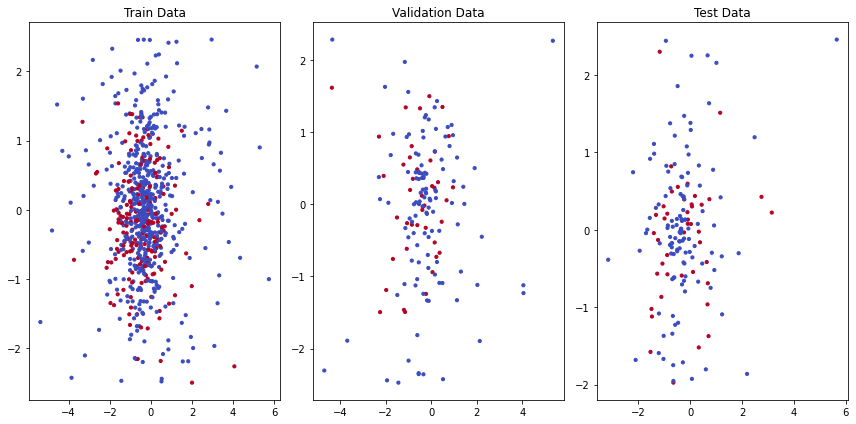

In [165]:

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings)
val_pca = pca.transform(val_embeddings)
test_pca = pca.transform(test_embeddings)

# Remove major outliers for better visualization from PCA and labels
x_mean = np.mean(train_pca[:, 0])
x_std = np.std(train_pca[:, 0])
y_mean = np.mean(train_pca[:, 1])
y_std = np.std(train_pca[:, 1])

# Prune outliers down to 1 standard deviation from the mean
pruned_train_pca = train_pca[(train_pca[:, 0] < x_mean + x_std) & (train_pca[:, 0] > x_mean - x_std) &
                             (train_pca[:, 1] < y_mean + y_std) & (train_pca[:, 1] > y_mean - y_std)]
pruned_train_labels = train_labels[(train_pca[:, 0] < x_mean + x_std) & (train_pca[:, 0] > x_mean - x_std) &
                                   (train_pca[:, 1] < y_mean + y_std) & (train_pca[:, 1] > y_mean - y_std)]

pruned_val_pca = val_pca[(val_pca[:, 0] < x_mean + x_std) & (val_pca[:, 0] > x_mean - x_std) &
                            (val_pca[:, 1] < y_mean + y_std) & (val_pca[:, 1] > y_mean - y_std)]
pruned_val_labels = val_labels[(val_pca[:, 0] < x_mean + x_std) & (val_pca[:, 0] > x_mean - x_std) &
                                (val_pca[:, 1] < y_mean + y_std) & (val_pca[:, 1] > y_mean - y_std)]

pruned_test_pca = test_pca[(test_pca[:, 0] < x_mean + x_std) & (test_pca[:, 0] > x_mean - x_std) &
                            (test_pca[:, 1] < y_mean + y_std) & (test_pca[:, 1] > y_mean - y_std)]
pruned_test_labels = test_labels[(test_pca[:, 0] < x_mean + x_std) & (test_pca[:, 0] > x_mean - x_std) &
                                (test_pca[:, 1] < y_mean + y_std) & (test_pca[:, 1] > y_mean - y_std)]


# Plot PCA embeddings
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(pruned_train_pca[:, 0], pruned_train_pca[:, 1], c=pruned_train_labels, cmap='coolwarm', s=10)
plt.title('Train Data')
plt.subplot(1, 3, 2)
plt.scatter(pruned_val_pca[:, 0], pruned_val_pca[:, 1], c=pruned_val_labels, cmap='coolwarm', s=10)
plt.title('Validation Data')
plt.subplot(1, 3, 3)
plt.scatter(pruned_test_pca[:, 0], pruned_test_pca[:, 1], c=pruned_test_labels, cmap='coolwarm', s=10)
plt.title('Test Data')
plt.tight_layout()
plt.show()



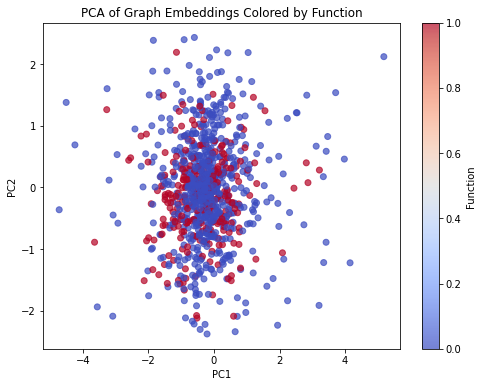

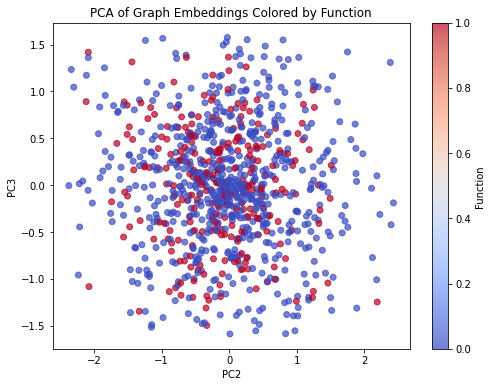

In [166]:
# Perform PCA and plot embeddings
from sklearn.decomposition import PCA

# Combine embeddings and labels
all_embeddings = np.concatenate([train_embeddings, val_embeddings, test_embeddings], axis=0)
all_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Prune outliers down to 1 standard deviation from the mean
x_mean = np.mean(pca_result[:, 0])
x_std = np.std(pca_result[:, 0])
y_mean = np.mean(pca_result[:, 1])
y_std = np.std(pca_result[:, 1])
z_mean = np.mean(pca_result[:, 2])
z_std = np.std(pca_result[:, 2])

# Prune outliers down to 1 standard deviation from the mean
pruned_pca_result = pca_result[(pca_result[:, 0] < x_mean + x_std) & (pca_result[:, 0] > x_mean - x_std) &
                               (pca_result[:, 1] < y_mean + y_std) & (pca_result[:, 1] > y_mean - y_std) &
                                 (pca_result[:, 2] < z_mean + z_std) & (pca_result[:, 2] > z_mean - z_std)]
pruned_labels = all_labels[(pca_result[:, 0] < x_mean + x_std) & (pca_result[:, 0] > x_mean - x_std) &
                            (pca_result[:, 1] < y_mean + y_std) & (pca_result[:, 1] > y_mean - y_std) &
                            (pca_result[:, 2] < z_mean + z_std) & (pca_result[:, 2] > z_mean - z_std)]

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pruned_pca_result[:, 0], pruned_pca_result[:, 1], c=pruned_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()

# Also plot PCA2 and PCA3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(all_embeddings)

# Plot PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pruned_pca_result[:, 1], pruned_pca_result[:, 2], c=pruned_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA of Graph Embeddings Colored by Function')
plt.colorbar(scatter, label='Function')
plt.show()


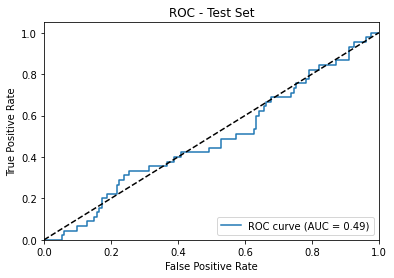

In [167]:
# Train a linear classifier on the embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare training and test data
X_train = train_embeddings
y_train = train_labels.squeeze()
X_test = test_embeddings
y_test = test_labels.squeeze()

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities
y_scores = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test Set')
plt.legend(loc='lower right')
plt.show()


Testing accuracy: 0.7486


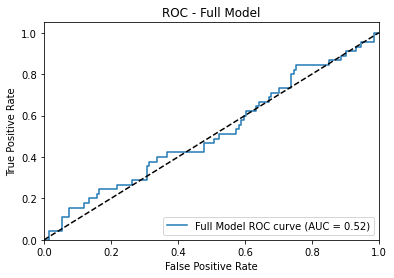

In [168]:
# Evaluate the full model on the test set and plot ROC curve
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out, _ = model(data)
        preds = torch.sigmoid(out).cpu().numpy()
        labels = data.y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

accuracy = get_accuracy(all_preds, all_labels)
print(f"Testing accuracy: {accuracy:.4f}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Full Model ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Full Model')
plt.legend(loc='lower right')
plt.show()


In [169]:
for val in preds:
    if val > .3:
        print(val)
#print(preds[0:10])

[0.3075612]
[0.30518866]
[0.32790327]
[0.32625842]


In [170]:
def get_smiles_vocab(train_df: pd.DataFrame) -> list:
    """
    Obtain all unique SMILES characters for our vocabulary
    Args: 
        trainData (DataFrame): Original training data

    Returns:
        list: The vocabulary list
    """
    vocabulary_set = set()
    vocabulary = []
    for index, row, in train_df.iterrows():
        #print(row)
        smiles = (row["SMILE"])
        for chr in smiles:
            #print(chr)
            if chr not in vocabulary_set:
                vocabulary_set.add(chr)
                vocabulary.append(chr)
            
    return vocabulary



In [171]:
#We may want to filter out some of these vocab elements, like the "." bc I thought we got rid of those?
smiles_chars = get_smiles_vocab(train_df)
print(smiles_chars)
char_to_idx = {char: idx for idx, char in enumerate(smiles_chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

char_to_idx[' '] = len(char_to_idx)  # Assign a new index for padding
idx_to_char[len(idx_to_char)] = ' '

#We try to ignore the padding later, so potentially -1?
vocab_size = len(char_to_idx)#len(smiles_chars) +1 padding chr
print(f"Length of vocabulary is {vocab_size}")

['[', 'H', ']', 'C', '@', '1', '2', '(', '=', 'O', ')', '3', '4', 'N', '#', '5', '6', '7', 'S', 'F', 'l', 'B', 'r', 'A', 's', 'P', '8', '9', '%', '0', 'a', '+', '.', '\\', '-', 'I', '/', 'M', 'g', 'i', 'n', 'u']
Length of vocabulary is 43


In [172]:
def encode_smiles(smiles: str) -> list:
    """
    Encodes SMILES strings to a list of indices.
    Args: 
        smiles (str): A SMILES string

    Returns:
        list: the SMILES string encoded
    
    """
    return [char_to_idx[char] for char in smiles]

def decode_indices(indices: list) -> str:
    """
    Decodes a list of indices back to a SMILES string.
    Args: 
        indicies (list): list of encoded SMILES string

    Returns:
        list: the decoded SMILES string
    
    """
    return ''.join([idx_to_char[idx] for idx in indices])

In [173]:
def get_vae_training_data(train_embeddings: np.ndarray, train_labels: np.ndarray) -> np.ndarray:
    """
    Obtain the embeddings of training samples that activate AR
    Args:
        train_embeddings (np.ndarray): the training embeddings
        train_labels (np.ndarray): binary activation labels for the embedded samples

    Return:
    np.ndarray: the activating embeddings
    
    """
    activating_embeddings = []
    for i, label in enumerate(train_labels):
        if label == 1:
            embedding = train_embeddings[i]
            activating_embeddings.append(embedding)
    
    activating_embeddings = np.array(activating_embeddings)
    return activating_embeddings 



In [174]:
def pad_smiles_indices(smiles_indices: List[List], padding_value=char_to_idx[' ']) -> torch.tensor:
    """
    Pads sequences with the padding character index, since the SMILES strings are different lengths
    
    Args:
        smiles_indices (list[list]): the list of mapped indices for SMILES strings
    Return: 
        torch.tensor

    """
    padded_smiles = pad_sequence([torch.tensor(smi, dtype=torch.long) for smi in smiles_indices],
                                 batch_first=True,
                                 padding_value=padding_value)
    return padded_smiles

In [175]:
def get_smiles_with_y_equals_one(data_loader: DataLoader) -> np.ndarray:
    """
    Pads sequences with the padding character index, since the SMILES strings are different lengths
    
    Args:
        data_loader (DataLoader): the unshuffled dataloader
    Return: 
        np.ndarray: the list of SMILES that activate AR (in order)

    """
    smiles_list = []
    for data in data_loader:
        for i in range(len(data.smiles)):
            if data.y[i].item() == 1:  # Check if y value is 1
                smiles_list.append(data.smiles[i])
    smiles_list = np.array(smiles_list)
    return smiles_list

In [176]:
# The goal of this section is to get the SMILES strings from the embeddings for molecules that activate the AR, so we can pass in both of those to decoder to learn. 

#Keep shuffle=False
train_loader_vae = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

smiles_with_y_one = get_smiles_with_y_equals_one(train_loader_vae)
train_embeddings_unshuffled, train_labels_unshuffled = get_embeddings_and_labels(model, train_loader_vae) 
train_embeddings_with_y_one = get_vae_training_data(train_embeddings_unshuffled, train_labels_unshuffled)

vae_train_smiles_indices = [encode_smiles(smile) for smile in smiles_with_y_one]
padded_vae_train_smiles_indices = pad_smiles_indices(vae_train_smiles_indices)

In [177]:
top = 0
for sm in vae_train_smiles_indices:
    length = len(sm)
    if length > top:
        top = length

print(top)

286


In [178]:
padded_vae_train_smiles_indices[0]

tensor([ 0,  1,  2,  0,  3,  4,  4,  2,  5,  6,  3,  3,  0,  3,  4,  1,  2,  7,
         3,  7,  8,  9, 10,  3,  9,  3,  7,  3, 10,  8,  9, 10,  0,  3,  4,  4,
         2,  5,  7,  3, 10,  3,  3,  0,  3,  4,  4,  2, 11,  7,  0,  1,  2, 10,
         0,  3,  4,  4,  2,  6,  7,  0,  1,  2, 10,  3,  3,  3, 12,  8,  3,  3,
         7,  8,  9, 10,  3,  3,  0,  3,  4,  2, 11, 12,  3, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 

In [179]:
train_dataset_vae_with_y_one = TensorDataset(torch.tensor(train_embeddings_with_y_one, dtype=torch.float32),
                              torch.tensor(padded_vae_train_smiles_indices, dtype=torch.long))

#NOTE: set shuffle=True once code works eventually
train_loader_vae_with_y_one = DataLoader(train_dataset_vae_with_y_one, batch_size=32, shuffle=False)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [180]:
train_dataset_vae_with_y_one[0]

(tensor([-0.8119,  0.0360,  0.0360]),
 tensor([ 0,  1,  2,  0,  3,  4,  4,  2,  5,  6,  3,  3,  0,  3,  4,  1,  2,  7,
          3,  7,  8,  9, 10,  3,  9,  3,  7,  3, 10,  8,  9, 10,  0,  3,  4,  4,
          2,  5,  7,  3, 10,  3,  3,  0,  3,  4,  4,  2, 11,  7,  0,  1,  2, 10,
          0,  3,  4,  4,  2,  6,  7,  0,  1,  2, 10,  3,  3,  3, 12,  8,  3,  3,
          7,  8,  9, 10,  3,  3,  0,  3,  4,  2, 11, 12,  3, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42

EVERYWHERE BELOW HERE IS PROBLEMATIC

In [181]:
#NOTE: THIS WHOLE CLASS SHOULD PROB GET DELETED AND REWORKED

class LSTMDecoder(nn.Module):
    """
    Model that decodes from a latent space

    Args:
        latent_dim (int): the dimensionality of the input embeddings
        hidden_dim (int): transforming inputs to different dimension
        vocab_size (int): number of unique characters in our SMILES vocab
        num_layers (int): depth of decoder
    """
    def __init__(self, latent_dim, hidden_dim, vocab_size, num_layers=2):
        super(LSTMDecoder, self).__init__()
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    #NOTE: THIS IS NOT CORRECT
    #Reduce max_length? the max length for a SMILES is in 80s i think
    def forward(self, z, max_length=100): #100
        batch_size = z.size(0)
        hidden = self.latent_to_hidden(z).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        input_token = torch.zeros(batch_size, 1, vocab_size)  # Start token, adjust as needed
        outputs = []

        for _ in range(max_length):
            output, (hidden, cell) = self.lstm(input_token, (hidden, cell))
            output_token = self.output_layer(output[:, -1, :])

            #eos_token = output_token.argmax(dim=-1)
            #print(eos_token)

            #print(output_token.shape)
            #print("----")
            outputs.append(output_token)
            #print(output_token.shape)
            input_token = F.one_hot(output_token.argmax(dim=-1), num_classes=vocab_size).float().unsqueeze(1)
            #print(input_token.)

        return torch.cat(outputs, dim=1)

In [182]:
class VAE(nn.Module):
    """
    Variational Autoencoder that only decodes an input sample

    Args:
        deocder (nn.Module): A decoder for the VAE
    """
    def __init__(self, decoder):
        super(VAE, self).__init__()
        self.decoder = decoder

    def sample(self, num_samples=1, latent_dim=3):
        #Sample from a standard normal distribution
        z = torch.randn(num_samples, latent_dim)
        return self.decoder(z)

In [188]:
# Set hyperparameters for deocder
latent_dim = 3  #Dimension of the 3D embeddings from the GNN
hidden_dim = 256
decoder = LSTMDecoder(latent_dim, hidden_dim, vocab_size)
vae = VAE(decoder)

criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx[' '])
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [189]:
"""
We are feeding in only activating samples to the VAE
"""
vae.train()
for epoch in range(3):
    for batch_embeddings, batch_smiles in train_loader_vae_with_y_one: 
        #print(batch_smiles)
        #break
        optimizer.zero_grad()
        outputs = vae.decoder(batch_embeddings, max_length=batch_smiles.size(1))
        loss = criterion(outputs.view(-1, vocab_size), batch_smiles.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 3.32120943069458
Epoch 2, Loss: 2.4919445514678955
Epoch 3, Loss: 2.4757513999938965


In [190]:
vae.eval()
with torch.no_grad():
    sampled_smiles = vae.sample(num_samples=1)


In [191]:
sampled = sampled_smiles.tolist()[0][0:100]
print(sampled)

[0.980890691280365, 0.7150738835334778, 0.7353604435920715, 1.4248123168945312, 0.7113081812858582, 0.49562591314315796, 0.3127272427082062, 0.7211874127388, 0.5586777329444885, 0.7329531908035278, 0.5813165307044983, 0.3029165267944336, 0.1954992264509201, 0.31505805253982544, -0.9474833011627197, -0.4336823523044586, -0.8488539457321167, -0.9842148423194885, -0.6261748671531677, -0.46313294768333435, -0.730658769607544, -1.0068128108978271, -0.9174289107322693, -0.7594702839851379, -0.7916661500930786, -0.9534225463867188, -0.8500396609306335, -0.9676243662834167, -0.8458354473114014, -0.9592797160148621, -0.8727298974990845, -0.8304743766784668, -0.8252063989639282, -0.8350796699523926, -0.8707148432731628, -0.8217777013778687, -0.8658725023269653, -0.7714517712593079, -0.8928000926971436, -0.7392668724060059, -0.7708543539047241, -1.0159727334976196, -0.868144690990448, 1.4015964269638062, 1.122809648513794, 1.3931704759597778, 2.351706027984619, 1.4623737335205078, 0.9785965085029

In [192]:
print(len(sampled))

100


In [193]:
print(min(sampled))
print(max(sampled))


-1.8701508045196533
3.137542724609375


In [194]:
def scale_list(numbers, max_length):
    min_val = min(numbers)
    max_val = max(numbers)
    
    scaled_numbers = [(x - min_val) / (max_val - min_val) * max_length for x in numbers]
    scaled_numbers = [int(x) for x in scaled_numbers]
    
    return scaled_numbers

In [195]:
tmp = scale_list(sampled, 42)

In [196]:
for i, val in enumerate(tmp):
    if val > 40:
        print(i)
        print(val)
        #print(val)

89
42


In [197]:
example = decode_indices(tmp)
print(example)
molecule = Chem.MolFromSmiles(example)
if molecule:
    print("Molecule successfully created")
else:
    print("Invalid SMILES string")

ABB9BFSBlBlS7S(4=()3O((OO(=(=(=======O=OO(=9P9I9AB9989Bl7](][@O1HHC][][][H][C]]]]HC][H+9+ .8P..0.sr7
Invalid SMILES string


[12:51:18] SMILES Parse Error: syntax error while parsing: ABB9BFSBlBlS7S(4=()3O((OO(=(=(=======O=OO(=9P9I9AB9989Bl7](][@O1HHC][][][H][C]]]]HC][H+9+
[12:51:18] SMILES Parse Error: Failed parsing SMILES 'ABB9BFSBlBlS7S(4=()3O((OO(=(=(=======O=OO(=9P9I9AB9989Bl7](][@O1HHC][][][H][C]]]]HC][H+9+' for input: 'ABB9BFSBlBlS7S(4=()3O((OO(=(=(=======O=OO(=9P9I9AB9989Bl7](][@O1HHC][][][H][C]]]]HC][H+9+'
